In [1]:
from matplotlib import pyplot as plt
import cv2
import os

import numpy as np
from scipy.io import loadmat
import scipy
import ml_collections

from jax import jit
from jax import numpy as jnp
import jax

from jwave import FourierSeries
from jwave.utils import load_image_to_numpy
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import Sensors, Medium, Domain, TimeAxis
from jwave.utils import show_field
from wavebench import wavebench_dataset_path

thick_lines_data_path = os.path.join(wavebench_dataset_path, "time_varying/thick_lines")



config = ml_collections
config.domain_sidelen = 512
config.domain_dx = 2

config.medium_source_loc = (199, 219)
config.medium_density = 2650

config.point_mass_strength = -31000
config.min_wavespeed = 1400
config.max_wavespeed = 4000

config.sigmaX = 200
config.pml_size = 10


domain = Domain(
    (config.domain_sidelen, config.domain_sidelen),
    (config.domain_dx, config.domain_dx))

MIN_SPEED = config.min_wavespeed
MAX_SPEED = config.max_wavespeed

#  define the properties of the propagation medium
z = np.ones((config.domain_sidelen,config.domain_sidelen))
z[config.medium_source_loc] = config.point_mass_strength

imf = cv2.GaussianBlur(
    z,
    ksize=(0, 0),
    sigmaX=config.sigmaX,
    borderType=cv2.BORDER_REPLICATE)


imf -= imf.min()
imf /= imf.max()

medium_sound_speed = imf*(MAX_SPEED - MIN_SPEED) + MIN_SPEED

medium = Medium(domain=domain, sound_speed=medium_sound_speed[..., np.newaxis])
medium.density = config.medium_density
medium.pml_size = config.pml_size

time_axis = TimeAxis.from_medium(medium, cfl=0.3, t_end=0.2)


@jit
def compute_final_pressure(medium, initial_pressure):
    final_pressure = simulate_wave_propagation(medium, time_axis, p0=initial_pressure)
    return final_pressure.on_grid.squeeze()[-1]


name_list = os.listdir(thick_lines_data_path)

# https://vmascagn.web.cern.ch/vmascagn/LABO_2020/numpy-memmap_for_ghost_imaging.html
rtc_dataset = os.path.join(wavebench_dataset_path, "time_varying/rtc")

initial_pressure_dataset = np.memmap(
    f'{rtc_dataset}/initial_pressure_dataset.npy', mode='w+',
    shape=(3000, 512, 512), dtype=np.float32)
final_pressure_dataset = np.memmap(
    f'{rtc_dataset}/final_pressure_dataset.npy', mode='w+',
    shape=(3000, 512, 512), dtype=np.float32)


for (idx, image) in enumerate(name_list[:10]):
    initial_pressure = load_image_to_numpy(
        f"{thick_lines_data_path}/{image}",
        image_size=(config.domain_sidelen, config.domain_sidelen))/255
    initial_pressure_dataset[idx, ...] = initial_pressure
    initial_pressure_dataset.flush()

    initial_pressure = jnp.expand_dims(initial_pressure, -1)
    initial_pressure = FourierSeries(initial_pressure, domain)
    final_pressure = compute_final_pressure(medium, initial_pressure)
    final_pressure_dataset[idx, ...] = final_pressure
    final_pressure_dataset.flush()

initial_pressure_dataset = np.memmap(
    f'{rtc_dataset}/initial_pressure_dataset.npy', mode='r',
    shape=(3000, 512, 512), dtype=np.float32)


final_pressure_dataset = np.memmap(
    f'{rtc_dataset}/final_pressure_dataset.npy', mode='r',
    shape=(3000, 512, 512), dtype=np.float32)

In [10]:
import numpy as np
import os
from wavebench import wavebench_dataset_path
import matplotlib.pyplot as plt
rtc_dataset = os.path.join(wavebench_dataset_path, "time_varying/rtc")


In [7]:
initial_pressure_dataset = np.memmap(
    f'{rtc_dataset}/initial_pressure_dataset.npy', mode='r',
    shape=(3000, 512, 512), dtype=np.float32)

final_pressure_dataset = np.memmap(
    f'{rtc_dataset}/final_pressure_dataset.npy', mode='r',
    shape=(3000, 512, 512), dtype=np.float32)


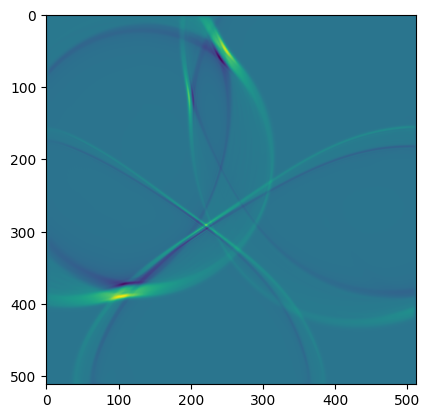

In [15]:
plt.imshow(np.array(final_pressure_dataset)[42] )

In [4]:
np.array(final_pressure_dataset).shape